# Significant test for DNN based on Brain-Tumor dataset

In [130]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision import models,datasets
from torch.utils import data
from torch.utils.data import dataset,dataloader
from PIL import Image
import json
import random
import imageio
import time
import copy
import gc
import os
import imutils

## Data loading and preprocessing

### Load data

In [92]:
dataset_path = '/Users/peihanyu/Research_Project/Sigtest_tumordata/brain_tumor_dataset'
paths = []
labels = []

for label in ['yes','no']:
    for dirname, _, filenames in os.walk(os.path.join(dataset_path,label)):
        for filename in filenames:
            paths.append(os.path.join(dirname, filename))
            labels.append(1 if label == 'yes' else 0)

print(len(paths), len(labels))


# image size details

sizes = []
for path in paths:
    im = Image.open(path)
    sizes.append(im.size)
    im.close()
    
print(max(sizes), min(sizes))
print(sizes)
print(paths)


253 253
(1920, 1080) (150, 198)
[(232, 309), (911, 938), (256, 256), (467, 586), (512, 512), (320, 355), (230, 219), (911, 938), (634, 929), (1061, 1280), (244, 308), (310, 380), (314, 340), (374, 456), (286, 370), (263, 300), (400, 431), (300, 347), (201, 251), (315, 350), (293, 337), (291, 340), (911, 938), (400, 431), (272, 350), (194, 260), (240, 300), (273, 318), (310, 355), (225, 225), (254, 325), (355, 450), (273, 342), (864, 938), (226, 223), (620, 620), (1275, 1427), (504, 630), (306, 365), (300, 325), (272, 355), (262, 351), (206, 244), (180, 218), (456, 519), (311, 355), (318, 380), (216, 234), (225, 225), (200, 210), (211, 239), (189, 173), (209, 212), (321, 352), (300, 359), (1059, 1200), (224, 245), (279, 344), (281, 352), (279, 354), (1024, 1024), (300, 325), (250, 294), (504, 630), (297, 359), (781, 960), (272, 331), (258, 279), (283, 295), (512, 512), (630, 630), (628, 630), (526, 555), (201, 251), (213, 236), (278, 351), (204, 251), (294, 380), (272, 277), (319, 360),

In [93]:
# stratified split into train and test

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(paths, 
                                                    labels, 
                                                    stratify=labels, 
                                                    test_size=0.2, 
                                                    shuffle=True, 
                                                    random_state=1357
                                                   )

print(len(X_train), len(X_test))

202 51


In [94]:
def crop_imgs(img, add_pixels_value=0):
    """
    Finds the extreme points on the image and crops the rectangular out of them
    """
    set_new = []
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # threshold the image, then perform a series of erosions +
    # dilations to remove any small regions of noise
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)

    # find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])

    ADD_PIXELS = add_pixels_value
    new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
    

    return new_img

In [95]:
class Braintumor_Dataset(data.Dataset):
    def __init__(self,paths,labels,augmentations = None):
        self.paths = paths
        self.labels = labels

        if augmentations is None:
            self.augmentations = transforms.Compose([transforms.ToTensor()])
        else: 
            self.augmentations = augmentations

    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, idx):

        label = self.labels[idx]

        sample = crop_imgs(cv2.imread(self.paths[idx]))
        
        sample = self.augmentations(Image.fromarray(sample))

        return (sample, torch.tensor(label, dtype = torch.float))

### Data augmentation

In [84]:
train_augmentations = transforms.Compose([transforms.Resize((224,224)),
                                          transforms.RandomAdjustSharpness(0.3),
                                          transforms.ColorJitter(brightness=10),
                                          transforms.ToTensor()
                                         ])

test_augmentations = transforms.Compose([transforms.Resize((224,224)),
                                          transforms.ToTensor()
                                         ])

In [96]:
train_dataset = Braintumor_Dataset(X_train, y_train, augmentations=train_augmentations)
test_dataset = Braintumor_Dataset(X_test, y_test, augmentations=test_augmentations)

In [86]:
random_sample, random_label = test_dataset[0]

### Show one of the picture after preprocessing

torch.Size([3, 224, 224])
1.0


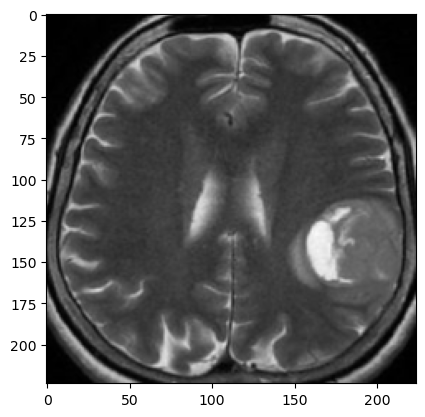

In [87]:
import matplotlib.pyplot as plt

random_sample, random_label = test_dataset[0]
print(random_sample.shape)
plt.imshow(random_sample.permute(1,2,0))
print(random_label.item())

In [120]:
class Config:
    learning_rate = 1e-3
    epochs = 10
    train_batch_size = 8
    test_batch_size = 8

In [90]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, 
                                               batch_size = Config.train_batch_size,
                                               shuffle = True,
                                               num_workers = 2
                                              )

test_dataloader = torch.utils.data.DataLoader(test_dataset,
                                              batch_size = Config.test_batch_size,
                                              shuffle = True,
                                              num_workers = 2
                                              )

len(train_dataloader), len(test_dataloader)

(26, 7)

## Use transfer learning(Resnet) to construct model 

### Model constructing

In [113]:
model_name = 'resnet'

feature_extract = True

In [116]:
def set_parameter_requires_grad(model,feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [117]:
model_ft = models.resnet18()

#print(model_ft)

In [118]:
def initialize_model(num_classes,feature_extract,use_pretrained = True):
    model_ft = models.resnet18(pretrained = use_pretrained)
    set_parameter_requires_grad(model_ft, feature_extract)

    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Linear(num_ftrs,num_classes)

    input_size = 64

    return model_ft,input_size


In [122]:
model_ft,input_size = initialize_model(2,feature_extract,use_pretrained = True)

nn_filename = 'best.pt'

params_to_update = model_ft.parameters()
print('Parameters to learn:')
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print('\t',name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print('\t',name)

Parameters to learn:
	 fc.weight
	 fc.bias


### Optimizer setting

In [129]:
optimizer_ft = optim.Adam(params_to_update, lr=1e-2)
scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma = 0.1)
criterion = nn.CrossEntropyLoss()

In [132]:
device = "cuda" if torch.cuda.is_available() else "cpu"


In [ ]:
  self.train, self.test = dataloaders

In [133]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=15,filename='best.pt'):
    #咱们要算时间的
    since = time.time()
    #也要记录最好的那一次
    best_acc = 0
    model = model.to(device)
    #训练过程中打印一堆损失和指标
    val_acc_history = []
    train_acc_history = []
    train_losses = []
    valid_losses = []
    #学习率
    LRs = [optimizer.param_groups[0]['lr']]
    #最好的那次模型，后续会变的，先初始化
    best_model_wts = copy.deepcopy(model.state_dict())
    #一个个epoch来遍历
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # 训练和验证
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # 训练
            else:
                model.eval()   # 验证

            running_loss = 0.0
            running_corrects = 0

            # 把数据都取个遍
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)#放到你的CPU或GPU
                labels = labels.to(device)

                # 清零
                optimizer.zero_grad()
                # 只有训练的时候计算和更新梯度
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, preds = torch.max(outputs, 1)
                # 训练阶段更新权重
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # 计算损失
                running_loss += loss.item() * inputs.size(0)#0表示batch那个维度
                running_corrects += torch.sum(preds == labels.data)#预测结果最大的和真实值是否一致
                
            
            
            epoch_loss = running_loss / len(dataloaders[phase].dataset)#算平均
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            
            time_elapsed = time.time() - since#一个epoch我浪费了多少时间
            print('Time elapsed {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            

            # 得到最好那次的模型
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                state = {
                  'state_dict': model.state_dict(),#字典里key就是各层的名字，值就是训练好的权重
                  'best_acc': best_acc,
                  'optimizer' : optimizer.state_dict(),
                }
                torch.save(state, filename)
            if phase == 'valid':
                val_acc_history.append(epoch_acc)
                valid_losses.append(epoch_loss)
                #scheduler.step(epoch_loss)#学习率衰减
            if phase == 'train':
                train_acc_history.append(epoch_acc)
                train_losses.append(epoch_loss)
        
        print('Optimizer learning rate : {:.7f}'.format(optimizer.param_groups[0]['lr']))
        LRs.append(optimizer.param_groups[0]['lr'])
        print()
        scheduler.step()#学习率衰减

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # 训练完后用最好的一次当做模型最终的结果,等着一会测试
    model.load_state_dict(best_model_wts)
    return model, val_acc_history, train_acc_history, valid_losses, train_losses, LRs 

In [ ]:
class Trainer:
    
    def __init__(self, model, dataloaders, Config):
        self.model = model
        self.train, self.test = dataloaders
        
        self.Config = Config
        
        self.optim = torch.optim.Adam(self.model.parameters(), lr=self.Config.learning_rate)
        self.loss_fn = nn.BCEWithLogitsLoss()
        
        
    def binary_accuracy(self, outputs, labels):
        return (torch.round(torch.sigmoid(outputs)) == labels).sum().item() / labels.shape[0]
        
        
    def train_one_epoch(self):
        
        running_loss = 0
        running_acc = 0
        
        for X,y in self.train:
            
            X = X.to(device, dtype = torch.float)
            y = y.reshape(y.shape[0],1)
            y = y.to(device, dtype = torch.float)
            
            self.optim.zero_grad()
            
            outputs = self.model(X)
            loss = self.loss_fn(outputs, y)
            
            loss.backward()
            self.optim.step()
            
            running_loss += loss.item()
            running_acc += self.binary_accuracy(outputs, y)
            
            del X
            del y
            gc.collect()
            torch.cuda.empty_cache()
            
        train_loss = running_loss / len(self.train)
        train_acc = running_acc / len(self.train)
        
        return train_loss, train_acc
            
    
    def fit(self):
        
        losses = []
        accuracies = []
        
        for epoch in range(self.Config.epochs):
            
            self.model.train()
            
            train_loss, train_acc = self.train_one_epoch()
            losses.append(train_loss)
            accuracies.append(train_acc)
            
            print(f"EPOCH {epoch+1}/{self.Config.epochs}")
            print(f"Training Loss: {train_loss} | Training Accuracy: {train_acc}\n\n")
            
    
    @torch.no_grad()
    def inference(self):
        
        self.model.eval()
    
        running_acc = 0
        
        for X,y in self.test:
            
            X = X.to(device, torch.float)
            y = y.reshape(y.shape[0],1)
            y = y.to(device, dtype = torch.float)
            outputs = self.model(X)
            running_acc += self.binary_accuracy(outputs, y)
            
            del X
            del y
            gc.collect()
            torch.cuda.empty_cache()
            
        accuracy = running_acc / len(self.test)
        
        return accuracy

In [135]:
model_ft, val_acc_history, train_acc_history, valid_losses, train_losses, LRs  = train_model(model_ft, (train_dataloader,test_dataloader), criterion, optimizer_ft, num_epochs=20)

Epoch 0/19
----------


TypeError: tuple indices must be integers or slices, not str